In [1]:
%load_ext autoreload
%autoreload 2

In [17]:

import os
import json
import pathlib
import pandas as pd
from datetime import datetime


In [3]:

from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

In [4]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [5]:
# where python source code located
import sys
code_path = os.path.abspath("../")

sys.path.append(code_path)

In [6]:
# utility modules or functions

from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser,
)

# WellClass
from src.WellClass.libs.well_class import Well

from src.WellClass.libs.grid_utils import (
    WellDataFrame,
    GridLGR,
    LGRBuilder,
)

# plots
from src.WellClass.libs.plotting import (
    plot_grid,
)


In [7]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Set up case scenario

In [8]:
# root directory for pflotran 
pflotran_working_root = '../test_data/examples/wildcat-pflotran'

In [11]:
# # Examples
wildcat = {
        'well_input': r'wildcat.yaml', 
        # 'well_input': r'wildcat.csv',
        'template': r'TEMP-0',    # for dry run, defined in 'model' folder
        'sim_case': r'WILDCAT',          # for lgr run, defined in 'model' folder
        }

In [12]:
############# 0. User options ######################

# TODO(hzh): use Ali's grid logic
Ali_way = False

# the root path for simulation
sim_path = pathlib.Path(pflotran_working_root)

# configuration filename
well_input = pathlib.Path(wildcat['well_input'])

# dry run: filename prefix on coarse grid, e.g., TEMP-0_NOSIM
template_simcase = wildcat['template']

# lgr run: filename prefix on lgr grid, e.g., TEMP-0
sim_case_LGR = wildcat['sim_case']

In [13]:

############# 1. computed parameters ######################

# extract suffix from the configuration file name
file_extension = well_input.suffix

# .yaml or .csv?
use_yaml = False
if file_extension in ['.yaml', '.yml']:
    use_yaml = True


In [15]:

# file prefix for dry run
# where eclipse .EGRID and .INIT files will be located
temp_simcase = sim_path/'model'/template_simcase
temp_simcase

PosixPath('../test_data/examples/wildcat-pflotran/model/TEMP-0')

In [16]:
# LGR
simcase = sim_path/'model'/sim_case_LGR
simcase

PosixPath('../test_data/examples/wildcat-pflotran/model/WILDCAT')

# Setup new copies of the CIRRUS/PFLOTRAN *.in and *grdecl files

In [20]:
# Read the template PFLOTRAN input file
template_file = temp_simcase.with_suffix('.in')
#Set up/verify paths for the resulting files
model_dir = sim_path / 'model'
include_dir = sim_path / 'include'

#Create directories if they do not exist
model_dir.mkdir(parents=True, exist_ok=True)
include_dir.mkdir(parents=True, exist_ok=True)

#Define variables for mapping grdecl files
template_grdecl = include_dir / 'TEMP_GRD.grdecl'
simcase_grdecl = include_dir / f'{sim_case_LGR}_GRD.grdecl'

#Create files for the simulation

# Read the template grdecl file and create an edited version to be included on the simulation case
with open(template_grdecl) as file:
    lines = file.readlines()
    
lines[5] = f'--{lines[5]}'  # comment out include file line

with simcase_grdecl.open('w') as file:
    file.writelines(lines)


#Read the template input file and create an edited version for the simulation case
with open(template_file.with_suffix('.in')) as file:
    lines = file.readlines()


start_date = datetime(2025,1,1) # Set start date for simulation
end_date = datetime(2025,1,1) # Set end date for simulation
title = 'LEGACY Well experiment - SCREEN simulation' # Set title for simulation

# Replace lines with new values
lines[1] = f'!{title}\n'
lines[34] = f' START_DATE  {start_date.strftime("%d %b %Y").upper()}\n'
lines[35] = f' FINAL_DATE  {end_date.strftime("%d %b %Y").upper()} \n'
lines[23] = f'  TYPE grdecl ../include/{simcase_grdecl.name} \n'


with simcase.with_suffix('.in').open('w') as file:
    file.writelines(lines)




# Read wellbore data

In [21]:
############ 2. Load well configuration file ###############

# where well configuration file is located
well_name = sim_path/well_input

if use_yaml:

        # # pydantic model
        well_model = yaml_parser(well_name)
        well_csv = json.loads(well_model.spec.model_dump_json())
else:

        # load the well information
        well_csv = csv_parser(well_name)

In [23]:
########### 3. build Well class ######################
# build well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
        )
# to well dataframe
well_df = WellDataFrame(my_well)

# for convenience
# extract dataframes
annulus_df = well_df.annulus_df
drilling_df = well_df.drilling_df
casings_df = well_df.casings_df
borehole_df = well_df.borehole_df
barriers_mod_df = well_df.barriers_mod_df


## Fecth info from well that will be used to define the vertical dimensions of the mesh

In [24]:
# Retrieve top reservoir depth
top_reservoir = well_df.geology_df.query('reservoir_flag == True')['top_msl'].min()

# Retrieve seafloor depth
top_overburden = my_well.header['sf_depth_msl']

# Define the thickness of the water column and the coarse overburden
water_column_thickness = top_overburden
coarse_overburden_thickness = (top_reservoir - top_overburden) - 5

# Define the thickness of the grid cells. 
tops_offset = 4
reservoir_cell_thickness = 5

grid_water_thickness = water_column_thickness - tops_offset
grid_coarse_thickness = (top_reservoir - top_overburden) - reservoir_cell_thickness #remove thickness of cap rock

#To make sure that no irrational numnbers are used we truncate the decimal places and add the residual to the top layer
cells_overburden_dz = grid_coarse_thickness // 9
cell_overbuden_dz_top = grid_coarse_thickness - (cells_overburden_dz * 8)

# Write the tops file
tops_file = include_dir / f'tops.inc'

with open(tops_file, 'w') as f:
	f.write("EQUALS\n")
	f.write("TOPS 4 4* 1 1 /\n")
	f.write("/\n\n")
	f.write("DZ\n")
	f.write(f"400*{grid_water_thickness} 400*{cell_overbuden_dz_top} 3200*{cells_overburden_dz} 20000*{reservoir_cell_thickness} /\n")
	f.write("/\n")

# Run coarse simulation

In [25]:
# file name (coarse grid) for pflotran run
run_config_coarse = simcase.with_suffix('.in')
run_config_coarse

PosixPath('../test_data/examples/wildcat-pflotran/model/WILDCAT.in')

In [26]:
%%bash -s "$run_config_coarse"

runcirrus -i -nm 6 $1


bash -c <SCRIPT>



 Cirrus 1.9sv3
 Cirrus was compiled on: Jan 16 2025 15:50:13            
 RESERVOIR_DEFAULTS keyword selected.
 Cirrus card:: DIMENS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: DZ                              
 Cirrus card:: EQUALS                          
 Cirrus card:: COPY                            
 Cirrus card:: MULTIPLY                        
 Cirrus card:: MINPV                           
 Calculating pore volumes
 Calculating connections
 Ncell=       24000  Nact=       24000  Nconn=       69200  Nflt=           0  Npo=           0
 Reading SUBSURFACE cards:
 Cirrus card:: GRID
 Cirrus card:: REFERENCE_PRESSURE
 Cirrus card:: REFERENCE_TEMPERATURE
 Cirrus card:: TIME
 Cirrus card:: OUTPUT
 Cirrus card:: NEWTON_SOLVER
 Cirrus card:: MATERIAL_PROPERTY
   Name :: formation
 "MATERIAL_PROPERTY,rock density units" set to default value.
 "MATERIAL_PROPERTY,specific heat units" set to default value.
 "MATERIAL_PROPERTY,dry thermal conduc

## Build LGR

In [28]:

##### LGR grid 
lgr = LGRBuilder(simcase, 
                 annulus_df, 
                 drilling_df,
                 Ali_way)

Coarse grid dimension: nx=20, ny=20, nz=60
Minimimum grid size is 5.24 cm
LGR dimension: nx=22, ny=22, nz=150


In [29]:
############### generate and output LGR #####################

LGR_NAME = f'LW_LGR'
output_dir = sim_path/'include'


# Write LGR file
gap_casing_df = lgr.build_grdecl(output_dir, 
                                 LGR_NAME,
                                 drilling_df,
                                 casings_df,
                                 barriers_mod_df)

gap_casing_df

...Prints isolating OVB from reservoir keywords in LW_LGR.grdecl file
...Prints CARFIN Keywords in LW_LGR.grdecl file
...Prints isolating OVB from reservoir in the LGR in LW_LGR.grdecl file
...reopenID = 12.25 ...
Output LGR CARFIN to:  /scratch/SCS/gpb/SCREEN/junk/SCREEN/test_data/examples/wildcat-pflotran/include/LW_LGR.grdecl


,top_rkb,bottom_rkb,diameter_in,toc_rkb,boc_rkb,shoe,cb_perm,diameter_m,top_msl,bottom_msl,toc_msl,boc_msl,n_grd_id,k_min,k_max,ij_min,ij_max,toc_k_min,toc_k_max
0,132,158,30.000,132,158,True,300,0.762000,105,131,105,131,12,10,12,5,16,10,12
1,132,439,20.000,132,439,True,5,0.508000,105,412,105,412,8,10,26,7,14,10,26
2,182,1803,13.375,450,1803,True,500,0.339725,155,1776,423,1776,6,13,81,8,13,27,81


# Run LGR simulation

In [30]:
# Update the grdecl file
with open(simcase_grdecl) as file:
    lines = file.readlines()

# Add the include file line so it reads the generated LGR file
lines[5] = f'external_file ../include/{LGR_NAME}.grdecl / \n'

with simcase_grdecl.open('w') as file:
    file.writelines(lines)


In [31]:
#Update the *.in file
with open(simcase.with_suffix('.in')) as file:
    lines = file.readlines()


# start_date = datetime(2025,1,1)
# end_date = datetime(2025,1,1+1)
# title = 'LEGACY Well experiment - SCREEN simulation'

# lines[1] = f'!{title}\n'
# lines[34] = f' START_DATE  {start_date.strftime("%d %b %Y").upper()}\n'
lines[35] = f' FINAL_DATE  {end_date.strftime("%d %b %Y").upper()} \n'
# lines[23] = f'  TYPE grdecl ../include/{simcase_grdecl.name} \n'






with simcase.with_suffix('.in').open('w') as file:
    file.writelines(lines)


In [33]:
# file name (LGR grid) for pflotran run
run_config_lgr = simcase.with_suffix('.in')
run_config_lgr

PosixPath('../test_data/examples/wildcat-pflotran/model/WILDCAT.in')

In [34]:
%%bash -s "$run_config_lgr"

runcirrus -i -nm 6 $1


bash -c <SCRIPT>



 Cirrus 1.9sv3
 Cirrus was compiled on: Jan 16 2025 15:50:13            
 RESERVOIR_DEFAULTS keyword selected.
 Cirrus card:: DIMENS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: CARFIN                          
 Cirrus card:: NXFIN                           
 Cirrus card:: NYFIN                           
 Cirrus card:: NZFIN                           
 Cirrus card:: HXFIN                           
 Cirrus card:: HYFIN                           
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS    

### Load files from pflotran simulation

In [35]:
# load LGR grid from simulation file
grid_lgr = GridLGR(simcase)

In [36]:
grid_lgr.lgr_index

,i,j,k,active,PORV,DX,DY,DZ,PERMX,PERMY,PERMZ,MULTX,MULTY,MULTZ,MULTX-,MULTY-,MULTZ-,TRANX,TRANY,TRANZ,PORO,DEPTH,NTG,SATNUM,FIPLEG
0,0,0,0,0,84729.476562,91.591797,91.591797,10.1,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.593820e+03,1593.819580,7082.537598,1.0,9.05,1.0,1,1
1,1,0,0,1,6838.548828,7.392409,91.591797,10.1,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.974727e+04,128.637787,571.634338,1.0,9.05,1.0,1,1
2,2,0,0,2,551.988281,0.596694,91.591797,10.1,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,2.430556e+05,10.383279,46.140705,1.0,9.05,1.0,1,1
3,3,0,0,3,48.462536,0.052388,91.591797,10.1,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.505729e+06,0.911614,4.050984,1.0,9.05,1.0,1,1
4,4,0,0,4,48.462536,0.052388,91.591797,10.1,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.505729e+06,0.911614,4.050984,1.0,9.05,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72595,17,21,149,72595,4.798271,0.052388,91.591797,5.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,7.454105e+04,0.000000,0.000000,0.2,2479.50,1.0,1,4
72596,18,21,149,72596,4.798271,0.052388,91.591797,5.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.203245e+04,0.000000,0.000000,0.2,2479.50,1.0,1,4
72597,19,21,149,72597,54.652306,0.596694,91.591797,5.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,9.775875e+02,0.000000,0.000000,0.2,2479.50,1.0,1,4
72598,20,21,149,72598,677.084045,7.392409,91.591797,5.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,7.890196e+01,0.000000,0.000000,0.2,2479.50,1.0,1,4


# Visualization

In [37]:
import inspect
inspect.getfile(plot_grid)

'/scratch/SCS/gpb/SCREEN/junk/SCREEN/src/WellClass/libs/plotting/plot_grids.py'

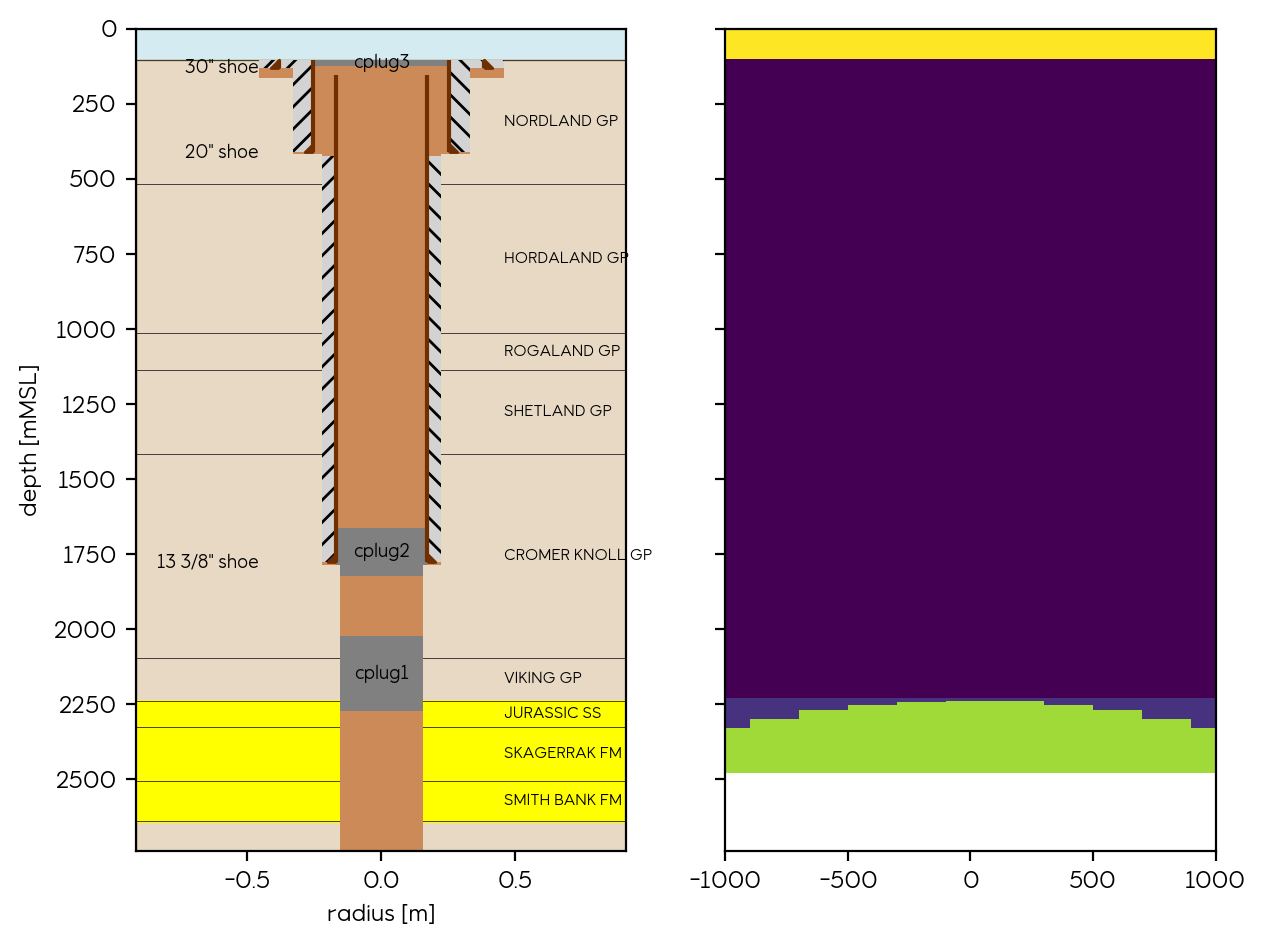

[]

In [38]:
# coarse grid
grid_coarse = lgr.grid_coarse

plot_grid(my_well, grid_coarse, prop='PERMX', )

import matplotlib.pyplot as plt

plt.get_fignums()

In [39]:
import matplotlib.pyplot as plt

# Retrieve a list of all active figures
figures = [plt.figure(num) for num in plt.get_fignums()]

# Display the figures
for fig in figures:
    fig.show()

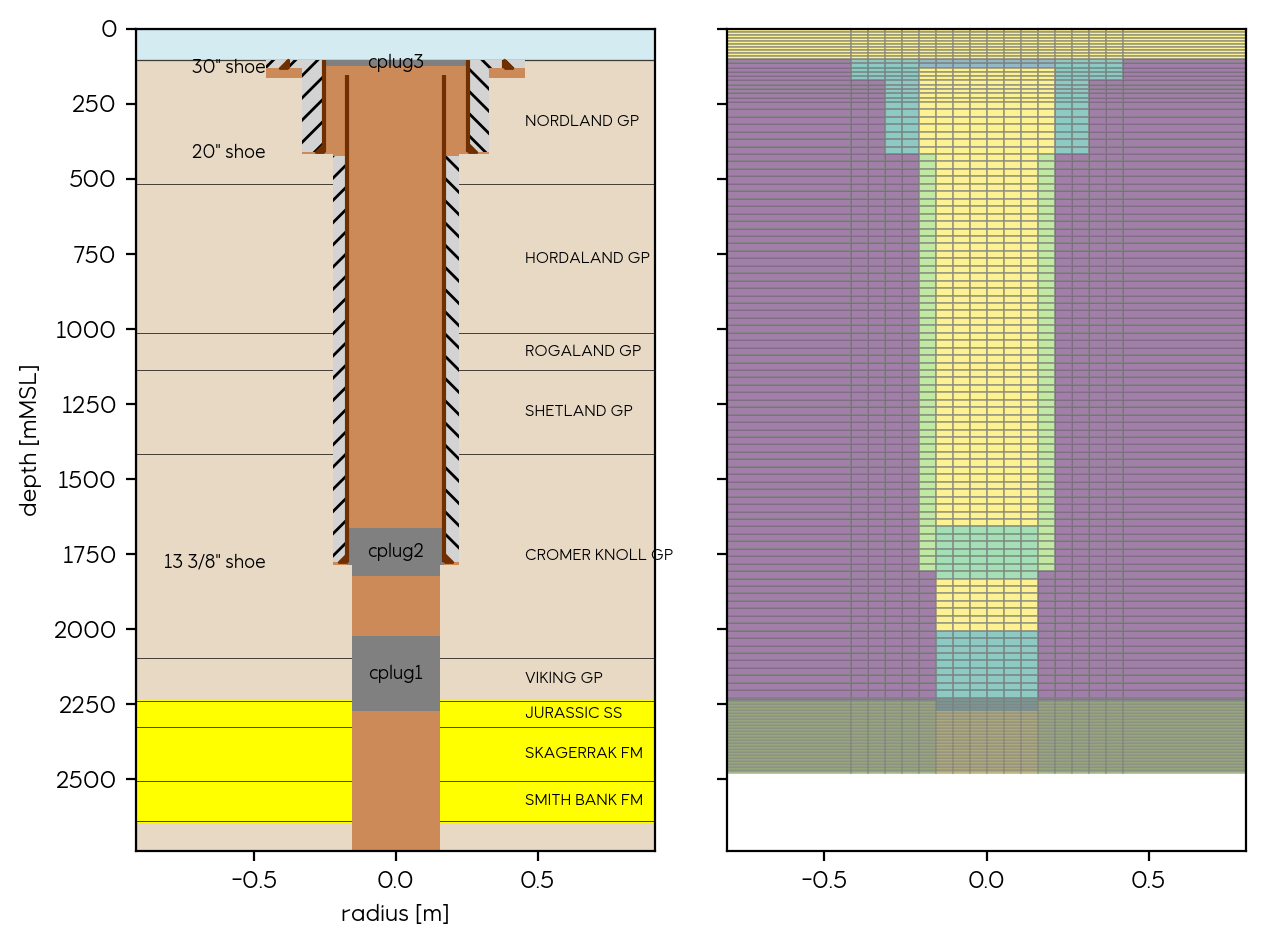

In [40]:
# LGR grid from pflotran output
PROPS = 'TRANZ'
PROPS = 'PERMX'
PROPS = 'PERMX'
# plot it
plot_grid(my_well, grid_lgr, prop=PROPS)

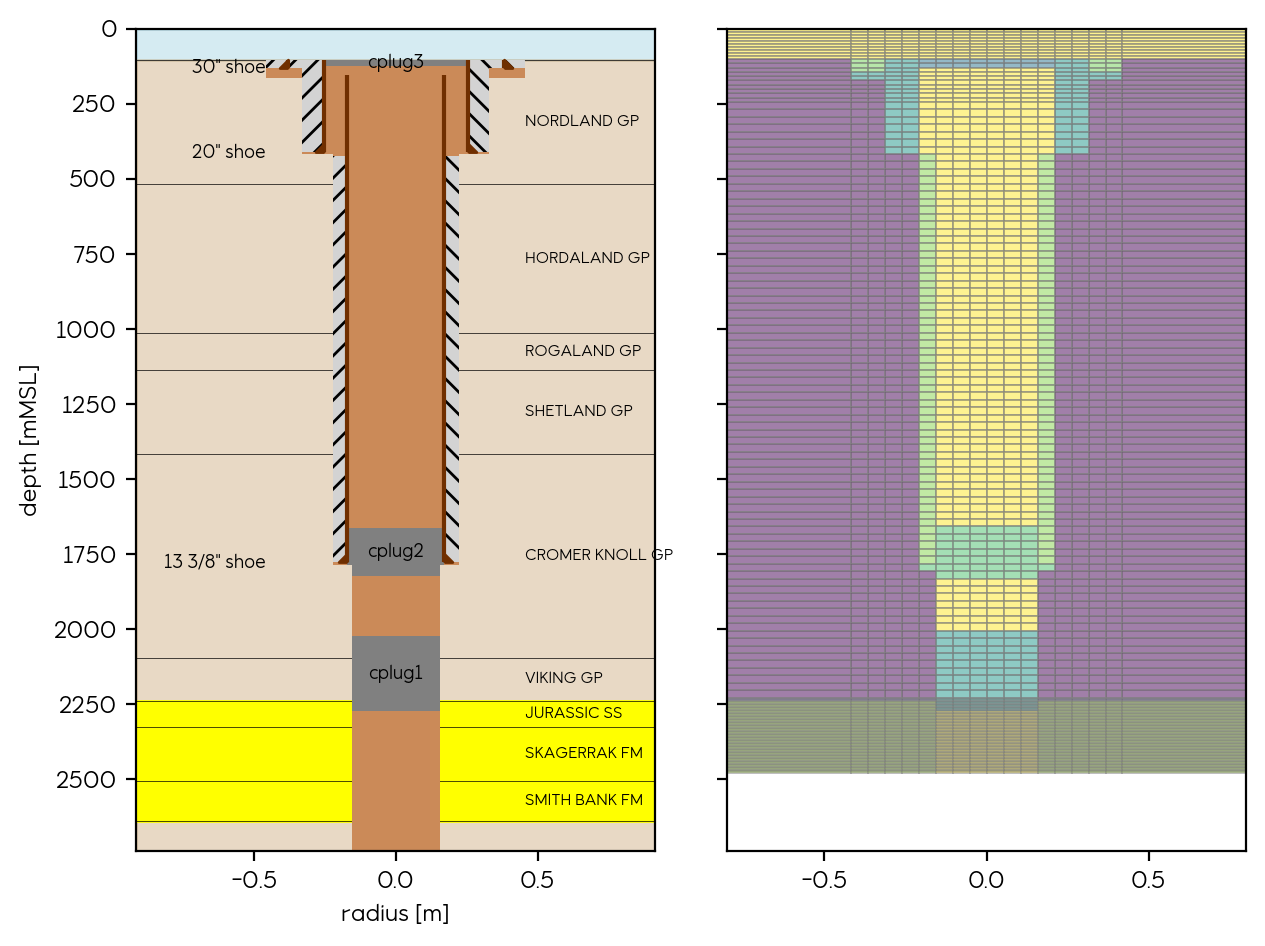

In [40]:
# LGR grid from dataframe
grid_refine = lgr.grid_refine

plot_grid(my_well, grid_refine)

# Other Qcs

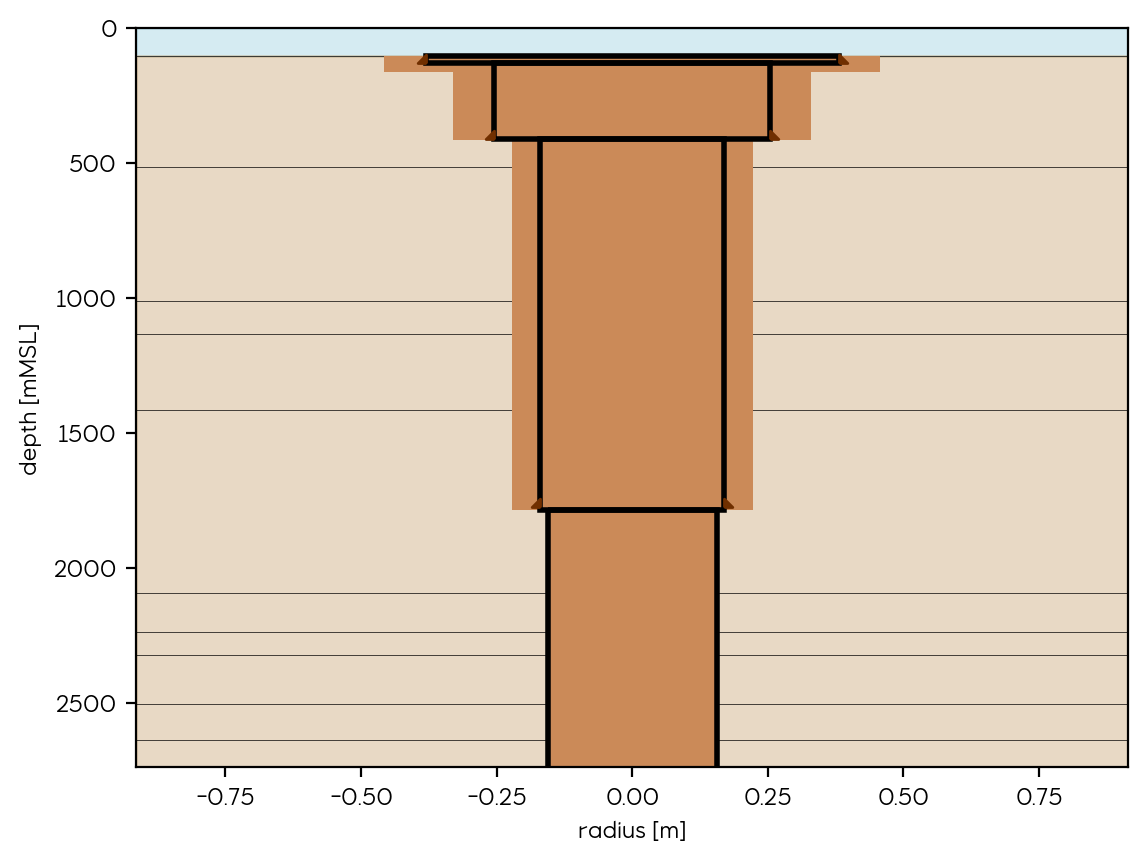

In [28]:
# testing plot_sketch
DEBUGGING = True
if DEBUGGING:
    from src.WellClass.libs.plotting import plot_sketch
    plot_sketch(my_well, 
                draw_annotation=False,
                draw_open_hole=True,
                draw_cement_bond=False,
                draw_casings=False, 
                draw_barriers=False)

In [29]:
ip_grid = grid_refine.mesh_df.sort_values(by=["k","j","i"])

In [30]:
type(ip_grid)

pandas.core.frame.DataFrame

In [31]:
# lgr mesh from simulation file
lgr_index = grid_lgr.lgr_index

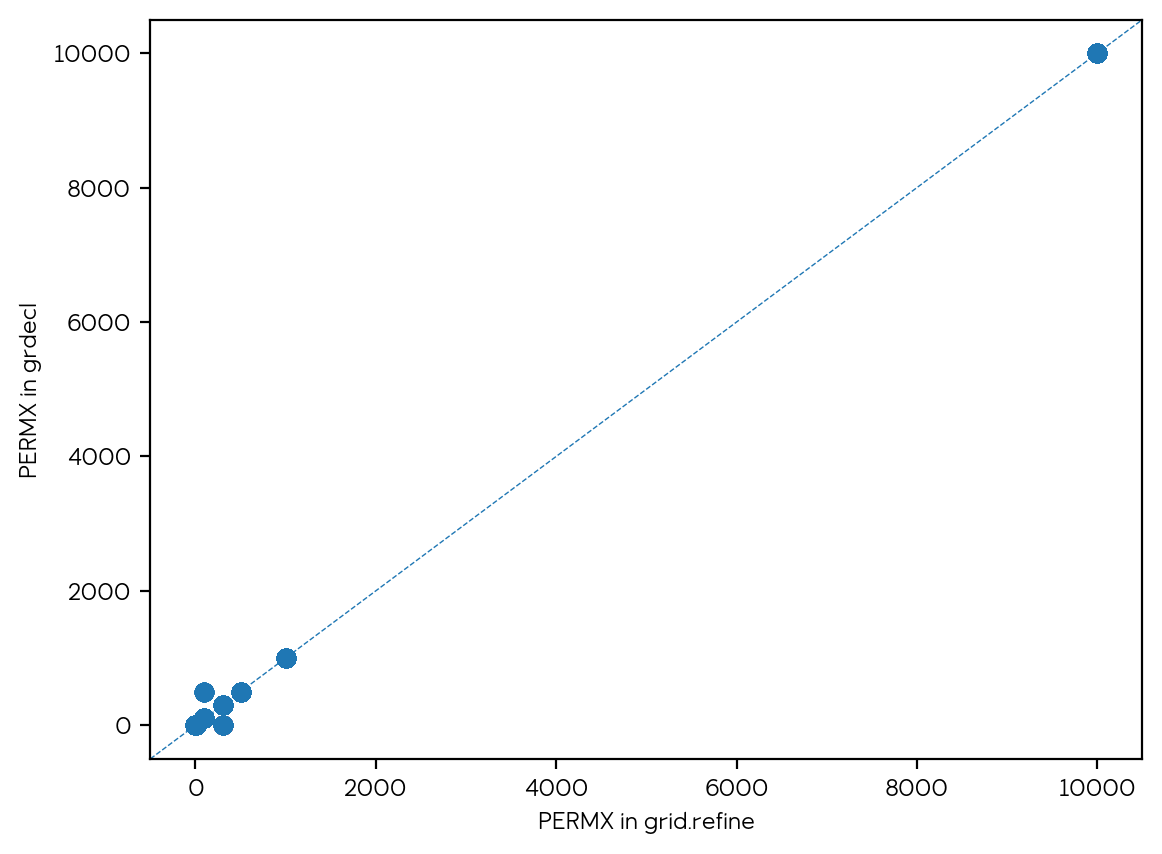

In [32]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
prop = 'PERMX'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')

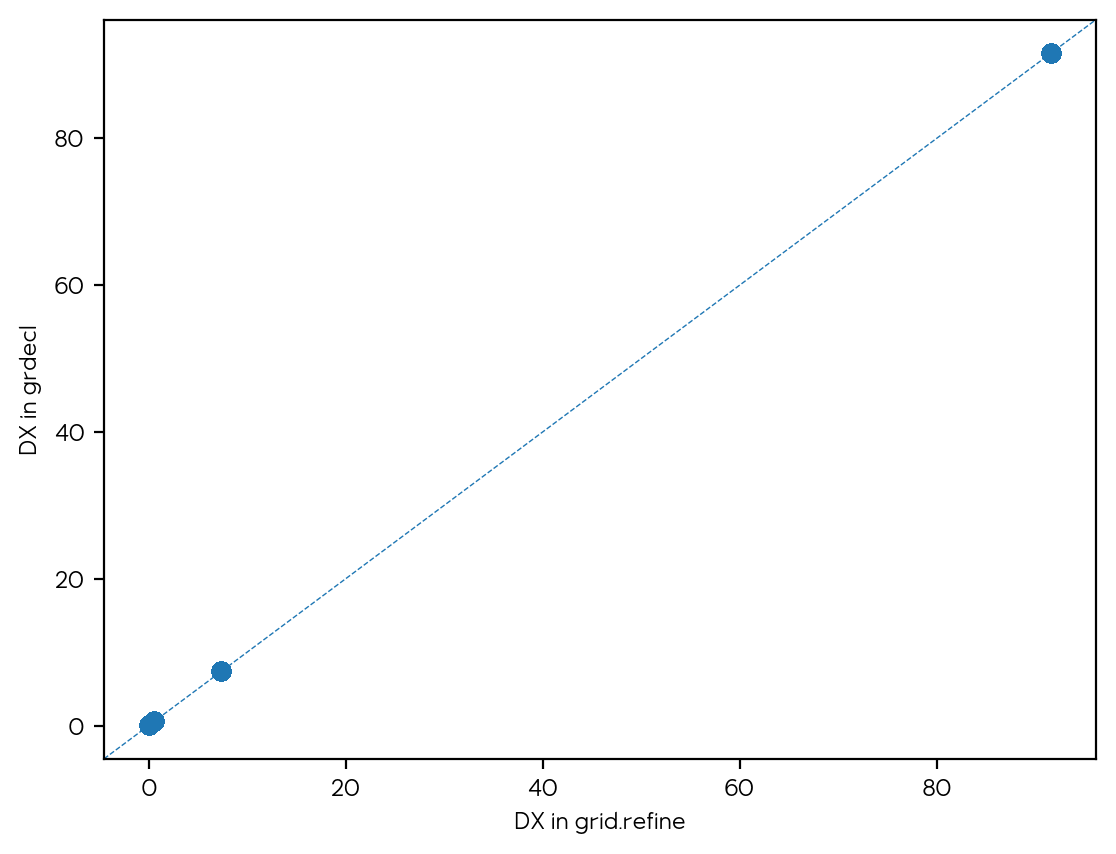

In [33]:
fig, ax = plt.subplots()
prop = 'DX'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')

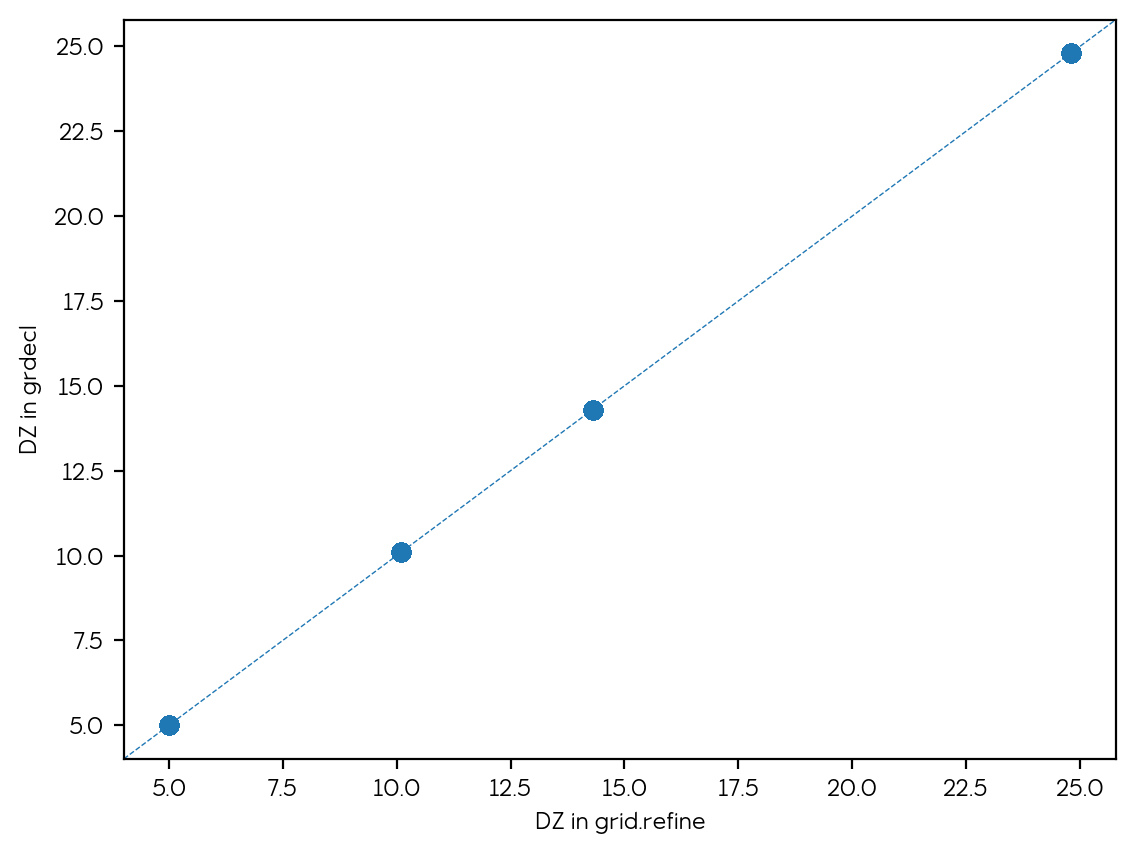

In [34]:
fig, ax = plt.subplots()
prop = 'DZ'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')